### Downloading the NVIDIA Stock Dataset with `kagglehub`

The snippet below shows how to fetch a specific version of the NVIDIA stock history from Kaggle using the `kagglehub` library:


In [1]:
import kagglehub

# Download selected version
path = kagglehub.dataset_download("adilshamim8/nvidia-stock-market-history/versions/1")

print("Path to dataset files:", path)

Path to dataset files: /Users/yungtingsoo/.cache/kagglehub/datasets/adilshamim8/nvidia-stock-market-history/versions/1


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob, os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

### Locating and Selecting a CSV File

This snippet finds and validates the first CSV file in the downloaded dataset directory:


In [3]:
# Build a list of all CSV paths in the dataset folder
csv_paths = glob.glob(os.path.join(path, "*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {path}")
csv_file = csv_paths[0]

### Loading the CSV into a Pandas DataFrame


In [4]:
df = pd.read_csv(csv_file, na_values=['null'], index_col='Date', parse_dates=True)
print(df.head())

               Close      High       Low      Open      Volume
Date                                                          
1999-01-22  0.037612  0.044775  0.035581  0.040119  2714688000
1999-01-25  0.041552  0.042029  0.037612  0.040597   510480000
1999-01-26  0.038328  0.042865  0.037731  0.042029   343200000
1999-01-27  0.038209  0.039403  0.036298  0.038447   244368000
1999-01-28  0.038089  0.038447  0.037850  0.038209   227520000


In [5]:
### Check for Any Missing Values in the DataFrame
df.isnull().values.any()

np.False_

In [6]:
### Inspecting the DataFrame’s Column Names
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

<Axes: title={'center': 'NVIDIA Close Price'}, xlabel='Date'>

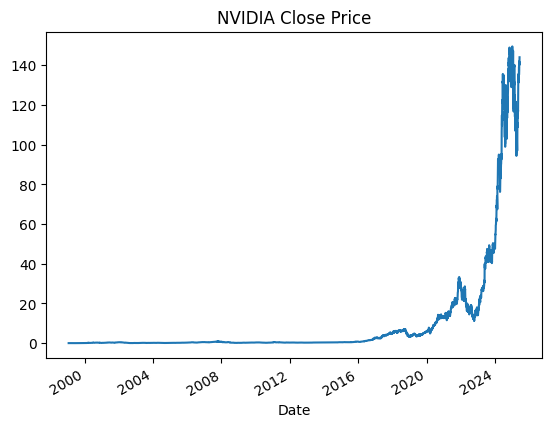

In [7]:
### Plotting the NVIDIA Closing Price Over Time

df['Close'].plot(title='NVIDIA Close Price')

In [8]:
### Defining the Target and Feature Sets

# Value of the stock at the end of the day to predict -- target variable
predict = pd.DataFrame(df['Close'])

# Features to use to predict the value of the stock -- input features
features = ['High', 'Low', 'Open', 'Volume']

### Normalizing Input Features with Min-Max Scaling
- **Why normalize?**
  - Neural networks (and many machine-learning algorithms) train more reliably and converge faster when all inputs share a similar scale. Here, we map each feature into the ```0,1``` range.

- **Steps explained**

  1. ```scaler = MinMaxScaler():```
     - Create a scaler that linearly transforms each feature so its minimum becomes 0 and its maximum becomes 1.
  2. ```scaler.fit_transform(df[features]):```
     - fit computes the min and max for each column in ```df[features]```.
     - transform applies the scaling to every value.
     - Returns a NumPy array of normalized values.
  4. ```pd.DataFrame(...):```
     - Wrap the scaled array back into a DataFrame, preserving the original column names and date index for easy alignment with our target series.
  5. ```features_normalised.head():```
     - Display the first few rows to confirm that each feature now lies between 0 and 1.

In [9]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

High       Low      Open    Volume
Date                                              
1999-01-22  0.000080  0.000034  0.000053  0.292580
1999-01-25  0.000062  0.000048  0.000056  0.053283
1999-01-26  0.000067  0.000048  0.000066  0.035123
1999-01-27  0.000044  0.000039  0.000042  0.024393
1999-01-28  0.000038  0.000049  0.000041  0.022564

### Time-Series Cross-Validation with `TimeSeriesSplit`
- **What it does**
  - ```TimeSeriesSplit(n_splits=10)``` creates 10 sequential “folds” over your data, preserving the chronological order.
  - On each iteration, you get two index arrays:
    - ```training_index``` covers all observations from the start through a certain cutoff.
    - ```test_index``` covers the immediately subsequent block of observations.
- **Logic**
  1. Chronological split: unlike random k-fold, the test set always comes after the train set in time.
  2. Expanding window: each fold’s training set grows larger, so you simulate forecasting with more and more history.
     - Fold 1: train on first 10%, test on next 10%
     - Fold 2: train on first 20%, test on next 10%
     - ... up to Fold 10.
- **How slicing works**
  - ```features_normalised[:len(training_index)]``` takes the first N rows as the training features.
  - ```features_normalised[N : N + M]``` takes the next M rows as the test features.
  - Same logic for the target series predict, where .values.ravel() converts it to a 1-D NumPy array.

- **Why use this?**
  - It gives you a more robust estimate of how your model performs over different time periods and market regimes, without ever “peeking” into the future.
  - It’s especially important for financial time-series, where random shuffling would violate the temporal dependencies you’re trying to model.

In [10]:
timesplit = TimeSeriesSplit(n_splits=10)

for training_index, test_index in timesplit.split(features_normalised):
    X_train, X_test = features_normalised[:len(training_index)], features_normalised[len(training_index): (len(training_index)+len(test_index))]
    y_train, y_test = predict[:len(training_index)].values.ravel(), predict[len(training_index): (len(training_index)+len(test_index))].values.ravel()

### Preparing the Input Array for the LSTM
- **Why convert to NumPy?**
  - Keras models expect inputs as NumPy arrays (not DataFrames) for efficient numerical computation.
- **Why reshape to 3D?**
  - LSTM layers require input of shape (batch_size, timesteps, features).
    - ```batch_size``` is the number of samples (rows) you feed per training step.
    - ```timesteps``` is how many past time steps the model sees at once—in this case we use 1 (one day of features).
    - ```features``` is the number of input variables per time step (here len(features), e.g., 4).
- **Effect of this code:**
  - ```train_X.shape``` goes from ```(N_samples, N_features)``` → ```(N_samples, 1, N_features)```.
  - Now each training example is a 1‐day sequence with all feature values, ready for the LSTM’s ```(timesteps, features)``` input.
  - The same reshaping applies to the test set so it matches the model’s expected input shape.

In [11]:
# Convert the pandas DataFrames to plain NumPy arrays
train_X = np.array(X_train)
test_X  = np.array(X_test)

# Reshape into 3D tensors of shape (samples, timesteps, features)
X_train = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
X_test  = np.reshape(test_X,  (test_X.shape[0],  1, test_X.shape[1]))

### Scaling the Target Variable
- ```MinMaxScaler()```
  - Creates a scaler that will linearly transform values into the ```0,1``` range.
- ```y_train.reshape(-1, 1)```
  - Ensures ```y_train``` is a 2-dimensional array with shape ```(n_samples, 1)```, as required by scikit-learn scalers.
- ```scaler_y.fit_transform(y_train)```
  1. ```fit``` computes the minimum and maximum of the training targets.
  2. ```transform``` scales each value: <br> $y_{scaled} = \frac{y - y_{min}}{y_{max} - y_{min}}$
  - The result, ```y_train_s```, is the scaled target array in ```0,1```.
- **Why scale the target?**
  - Matching the scaled range of ```X_train``` and ```y_train``` helps the LSTM converge faster and avoids weight‐update issues caused by large numeric differences.

In [12]:
scaler_y = MinMaxScaler()
y_train = y_train.reshape(-1,1)
y_train_s = scaler_y.fit_transform(y_train)

### Build & Compile the LSTM Model
- **Architecture logic**
  - ```LSTM(128)```
    - Processes each input sequence (of length 1) and produces a 128-dimensional hidden state.
    - ```activation='relu'``` lets the network capture nonlinear relationships.

- ```Dense(1)```
  - A fully connected layer that projects the 128-dim hidden vector down to a single scalar prediction (next-day close price).
- **Compilation choices**
  - Optimizer: ```adam```
    - Combines momentum and adaptive learning rates for fast, stable convergence.
  - Loss: ```mse```
    - Penalizes large errors more heavily, appropriate for continuous regression.
  - Metrics: ```mae```
    - Provides an interpretable error in the original units (USD), useful for monitoring.

- **```model.summary()```**
  - Verifies your layer stack and shows parameter counts, ensuring your Dense layer is correctly attached after the LSTM.

In [13]:
# 1) Define the model architecture
lstm_model = Sequential([
    # LSTM layer with 128 hidden units
    # - activation='relu' helps with non-linear patterns
    # - input_shape=(timesteps, features) here is (1, X_train.shape[2])
    LSTM(128, activation='relu', input_shape=(1, X_train.shape[2])),
    # Dense layer to map the LSTM’s 128-dim output down to a single value
    Dense(1)
])

# 2) Compile the model for training
lstm_model.compile(
    optimizer='adam',    # adaptive learning rate algorithm
    loss='mse',          # mean squared error for regression
    metrics=['mae']      # track mean absolute error as an additional metric
)

# 3) Sanity-check the architecture
lstm_model.summary()   # should list two layers: LSTM (None,128) → Dense (None,1)

/Users/yungtingsoo/Desktop/StockAnalysis/stock/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)